In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import zero_pad
from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_initial_draw import kalman_initial_draw
from probDE.Kalman import kalman_ode_higher
from probDE.Kalman.higher_mvncond import higher_mvncond
from probDE.cython.kalman_ode_higher import kalman_ode_higher as kalman_ode_higher_cy
#from linalg.mat_mult import mat_mult, mat_vec_mult

In [2]:
%load_ext Cython

In [3]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

cpdef ode_fun(double[::1] x_t, double t):
    return sin(2*t) - x_t[0]

cpdef rand_mat(int n, int p, bint pd=True):
    cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) and pd:
        V[:] = np.matmul(V, V.T)
    return V

In [4]:
def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [5]:
N = 50
q = 2
p = q+2
tmin = 0
tmax = 10
delta_t = np.array([(tmax-tmin)*1/N])
w = np.array([0. , 0., 1.])
wgt_meas = zero_pad(w, p)
x0 = np.array([-1., 0., 0.])
x0 = np.array([-1.0, 0.0, ode_fun(x0, 0)]) #Initial state
r0 = 500
sigma = 0.5
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
x0_state = kalman_initial_draw(roots, sigma, x0, p)
wgt_state, var_state = higher_mvncond(delta_t, roots, sigma) 
mu_state = np.zeros(p)
z_state_sim = rand_mat(2*N, p)

Yn_chk_mean, Yn_chk_var = kalman_ode_higher(ode_fun, x0_state, tmin, tmax, N-1, 
                                            wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

In [6]:
Yn_chk_mean2, Yn_chk_var2 = kalman_ode_higher_cy(ode_fun, x0_state, tmin, tmax, N-1, 
                                               wgt_state, mu_state, var_state, 
                                               wgt_meas, z_state_sim)

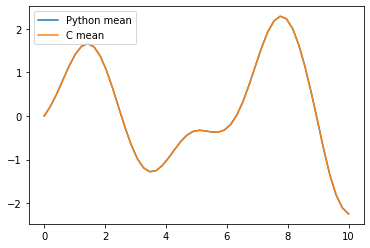

In [7]:
tseq = np.linspace(tmin, tmax, N)
plt.plot(tseq, Yn_chk_mean[:, 1], label = 'Python mean')
#plt.plot(tseq, Yn[:, 1], label = 'Python sample')
plt.plot(tseq, Yn_chk_mean2[1], label = 'C mean')
#plt.plot(tseq, Yn2[1], label = 'C sample')
plt.legend(loc='upper left')

## Python, Cython, Odeint Timings

In [ ]:
py = %timeit -o -n 100 Yn_chk_mean, Yn_chk_var = \
    kalman_ode_higher(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

In [ ]:
cy = %timeit -o -n 100 Yn_chk_mean2, Yn_chk_var2 = \
    kalman_ode_higher_cy(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

In [ ]:
py.average/cy.average

In [ ]:
from scipy import integrate
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [ ]:
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)
#cy.average/ode.average

## Pre-allocated Memorization

In [8]:
from kalman_ode_solve_py import kalman_ode_solve_py
from probDE.cython.kalman_ode_solve_cy import kalman_ode_solve_cy

In [9]:
# argumgents for kalman_filter and kalman_smooth
n_dim_meas = 1
n_dim_state = p
n_steps = N
DTYPE = np.double
mu_meas = np.zeros(n_dim_meas, dtype=DTYPE, order='F')
var_meass = np.zeros((n_dim_meas, n_dim_meas, n_steps),dtype=DTYPE, order='F')
x_meass = np.zeros((n_dim_meas, n_steps),dtype=DTYPE)
mu_state_filts = np.zeros((n_dim_state, n_steps),dtype=DTYPE, order='F')
var_state_filts = np.zeros((n_dim_state, n_dim_state, n_steps),dtype=DTYPE, order='F')
mu_state_preds = np.zeros((n_dim_state, n_steps), dtype=DTYPE, order='F')
var_state_preds = np.zeros((n_dim_state, n_dim_state, n_steps), dtype=DTYPE, order='F')
mu_state_smooths = np.zeros((n_dim_state, n_steps), dtype=DTYPE, order='F')
var_state_smooths = np.zeros((n_dim_state, n_dim_state, n_steps),dtype=DTYPE, order='F')
x_state_smooths = np.zeros((n_dim_state, n_steps),dtype=DTYPE, order='F')
x_state_tt = np.zeros(n_dim_state, dtype=DTYPE, order='F') #Temporary state simulation for interrogation
var_state_meas = np.zeros((n_dim_meas, n_dim_state),dtype=DTYPE, order='F') #Temporary matrix for multi_dot
x_meas_ = np.zeros(n_dim_meas, dtype=DTYPE, order='F') #Temporary for matrix vector multi

In [10]:
solve_py = %timeit -o -n 100 _, _ = \
    kalman_ode_solve_py(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                       mu_meas, var_meass, x_meass, mu_state_filts, var_state_filts, mu_state_preds, \
                       var_state_preds, mu_state_smooths, var_state_smooths, x_state_smooths, x_state_tt)

8.66 ms ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
solve_cy = %timeit -o -n 100 _, _ = \
    kalman_ode_solve_cy(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, mu_meas, \
                        var_meass, x_meass, mu_state_filts, var_state_filts, mu_state_preds, var_state_preds, \
                        mu_state_smooths, var_state_smooths, x_state_smooths, x_state_tt, var_state_meas, x_meas_)

## Offline

In [ ]:
from kalman_ode_offline_py import kalman_ode_offline_py
from probDE.cython.kalman_ode_offline_cy import kalman_ode_offline_cy

In [ ]:
offline_cy = %timeit -o -n 100 _, _ = \
    kalman_ode_offline_cy(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                          x_meass, offline=True)

In [ ]:
offline_py = %timeit -o -n 100 _, _ = \
    kalman_ode_offline_py(ode_fun, x0_state, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                          x_meass, filter_only=True, offline=True)

## C++ allocated memory


In [11]:
from probDE.cython.KalmanTest.kalmantest import KalmanTest

In [12]:
# argumgents for kalman_filter and kalman_smooth
n_dim_meas = 1
n_dim_state = p
n_steps = N
DTYPE = np.double
mu_state_smooths = np.zeros((n_dim_state, n_steps), dtype=DTYPE, order='F')
var_state_smooths = np.zeros((n_dim_state, n_dim_state, n_steps),dtype=DTYPE, order='F')
ktest = KalmanTest(n_dim_meas, n_dim_state, n_steps)

In [13]:
kalmantest_cy = %timeit -o -n 100 ktest.filter_smooth(mu_state_smooths, var_state_smooths, x0_state, wgt_state, mu_state, var_state, wgt_meas, x_meass, z_state_sim)

105 µs ± 9.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Python to Cython Comparisons of `fun` and `rand_mat`

In [ ]:
def rand_mat_py(n, p=None, pd=True):
    """Generate a random matrix, positive definite if `pd = True`."""
    if p is None:
        p = n
    V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) & pd:
        V[:] = np.matmul(V, V.T)
    return V

In [ ]:
%timeit rand_mat(2*N, p)

In [ ]:
%timeit rand_mat_py(2*N, p)

In [ ]:
def ode_fun_py(x_t, t):
    return sin(2*t) - x_t[0]

In [ ]:
%timeit ode_fun(x_0, 0)

In [ ]:
%timeit ode_fun_py(x_0, 0)

## Blas/Lapack

In [ ]:
def rel_err(X1, X2):
    """Relative error between two numpy arrays."""
    return np.max(np.abs((X1.ravel() - X2.ravel())/X1.ravel()))

In [ ]:
m = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,n), order='F')
x = np.random.rand(n)
y = np.zeros(m, order='F')

In [ ]:
mat_vec_mult(A, x, y)
np.testing.assert_almost_equal(rel_err(A.dot(x), y), 0.0)

In [ ]:
m = np.random.randint(2,10)
k = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,k), order='F')
B = np.array(np.random.rand(k,n), order='F')
C = np.zeros((m,n), order='F')

In [ ]:
x0_state.shape

In [ ]:
mat_mult(A, B, C)
np.testing.assert_almost_equal(rel_err(np.matmul(A, B), C), 0.0)

## Scratch

In [15]:
%%cython --compile-args='-O3'
cimport cython
import numpy as np
cimport numpy as np
from probDE.cython.KalmanTest.kalmantvpre import KalmanTVPre
from probDE.cython.mat_mult import mat_mult, mat_vec_mult

DTYPE = np.double
ctypedef np.double_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef kalman_ode_pre(fun,
                     double[::1] x0_state,
                     int n_eval, 
                     double[::1, :] wgt_state,
                     double[::1] mu_state, 
                     double[::1, :] var_state,
                     double[::1, :] wgt_meas, 
                     double[::1, :] z_state_sim,
                     double[::1, :] x_meass,
                     bint smooth_mv=True,
                     bint smooth_sim=False):
    # Dimensions of state and measure variables
    cdef int n_dim_meas = wgt_meas.shape[0]
    cdef int n_dim_state = mu_state.shape[0]
    cdef int n_steps = n_eval + 1
    # argumgents for kalman_filter and kalman_smooth
    cdef np.ndarray[DTYPE_t, ndim=2] mu_state_smooths = np.zeros((n_dim_state, n_steps),
                                                                 dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=3] var_state_smooths = np.zeros((n_dim_state, n_dim_state, n_steps),
                                                                  dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] x_state_smooths = np.zeros((n_dim_state, n_steps),
                                                                dtype=DTYPE, order='F')
    #cdef np.ndarray[DTYPE_t, ndim=1] x_state_tt = np.zeros(n_dim_state, 
    #                                                       dtype=DTYPE, order='F') #Temporary state simulation for interrogation
    #cdef np.ndarray[DTYPE_t, ndim=2] var_state_meas = np.zeros((n_dim_meas, n_dim_state),
    #                                                       dtype=DTYPE, order='F') #Temporary matrix for multi_dot
    #cdef np.ndarray[DTYPE_t, ndim=1] x_meas_ = np.zeros(n_dim_meas, dtype=DTYPE, order='F') #Temporary for matrix vector multi
    cdef int t
    
    # forward pass
    ktvpre = KalmanTVPre(n_dim_meas, n_dim_state, n_steps, x0_state)
    for t in range(n_eval):
        # kalman filter:
        ktvpre.filter(cur_step = t,
                      mu_state = mu_state,
                      wgt_state = wgt_state,
                      var_state = var_state,
                      x_meas = x_meass[:, t+1],
                      wgt_meas = wgt_meas)
    # backward pass
    ktvpre.smooth_update(x_state_smooth = x_state_smooths[:, n_eval],
                         mu_state_smooth = mu_state_smooths[:, n_eval],
                         var_state_smooth = var_state_smooths[:, :, n_eval],
                         z_state = z_state_sim[:, n_eval])

    for t in reversed(range(n_eval)):
        if smooth_mv and smooth_sim: 
            ktvpre.smooth(cur_step = t,
                          x_state_smooth = x_state_smooths[:, t],
                          mu_state_smooth = mu_state_smooths[:, t],
                          var_state_smooth = var_state_smooths[:, :, t], 
                          x_state_next = x_state_smooths[:, t+1],
                          mu_state_next = mu_state_smooths[:, t+1],
                          var_state_next = var_state_smooths[:, :, t+1],
                          wgt_state = wgt_state,
                          z_state = z_state_sim[:, (n_eval+1)+t])
        elif smooth_mv:
            ktvpre.smooth_mv(cur_step = t,
                             mu_state_smooth = mu_state_smooths[:, t],
                             var_state_smooth = var_state_smooths[:, :, t],
                             mu_state_next = mu_state_smooths[:, t+1],
                             var_state_next = var_state_smooths[:, :, t+1],
                             wgt_state = wgt_state)
        elif smooth_sim:
            ktvpre.smooth_sim(cur_step = t,
                              x_state_smooth = x_state_smooths[:, t],
                              x_state_next = x_state_smooths[:, t+1],
                              wgt_state = wgt_state,
                              z_state = z_state_sim[:, (n_eval+1)+t])

    if smooth_mv and smooth_sim:
        return x_state_smooths, mu_state_smooths, var_state_smooths
    elif smooth_mv:
        return mu_state_smooths, var_state_smooths
    elif smooth_sim:
        return x_state_smooths


In [18]:
DTYPE = np.double
n_eval = N-1
mu_state_smooths = np.zeros((n_dim_state, n_steps), dtype=DTYPE, order='F')
var_state_smooths = np.zeros((n_dim_state, n_dim_state, n_steps),dtype=DTYPE, order='F')

In [28]:
pre_cy = %timeit -o -n 100 _, _ =\
kalman_ode_pre(ode_fun, x0_state, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, x_meass)

928 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
pre_sim_cy = %timeit -o -n 100 _, _, _ =\
kalman_ode_pre(ode_fun, x0_state, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, x_meass, smooth_sim=True)

1.23 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
